In [2]:
#necessary imports
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
image_directory = 'training-images-2' #image path
image_size = [250, 250] #image size
# read_images gives the corresponding images and the labels associated with it
def read_images(image_path=image_directory, default_size=image_size):
    images = []
    labels = []
    names = [image for image in os.listdir(image_path) if not image.startswith('.')]
    for name in names:
        dir_path = os.path.join(image_path, name)
        image_names = [image for image in os.listdir(dir_path) if not image.startswith('.')]
        for image_name in image_names:
            image = Image.open (os.path.join(dir_path, image_name))
            image = image.convert ("L") #convert to black and white
            if (default_size is not None ):#resize to the default size
                image = image.resize (default_size , Image.ANTIALIAS )
            images.append(np.asarray (image , dtype =np. uint8 ))
            labels.append(name)
    return [images,labels]

In [4]:
#convert function helps flatten all the images into a 1d array so we can perform PCA on it
def convert (X):
    if len (X) == 0:
        return np.array([])#return empty row
    matrix = np.empty((0, X[0].size),dtype = X[0].dtype)
    for row in X:
        matrix = np.vstack((matrix ,np.asarray(row).reshape(1,-1))) #reshape to 1-D array
    return matrix

C:\Users\Haikoo Khandor\AppData\Local\Temp\ipykernel_6920\1357855690.py:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize (default_size , Image.ANTIALIAS )


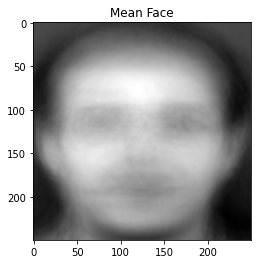

In [5]:
[X, y] = read_images()      
mean_face = np.reshape(convert(X).mean(axis =0), X[0].shape) # add all the images to get the mean 
plt.imshow(mean_face, cmap=plt.cm.gray)
plt.title("Mean Face")
plt.show()

In [6]:
def num_components_for_variance(eigenvalues, variance=.95): #finding points having variance greater than 95%
    for number, eigenvalue in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
        if eigenvalue>variance:
            return number
def PCA(X, y, num_components = 0):
    [n,d] = X.shape
    if (num_components <= 0) or (num_components > n): #handling edge cases
        num_components = n
        mu = X.mean(axis = 0) #subtracting each point from the mean
        X = X - mu
    if n>d:
        C = np.dot(X.T,X) 
        [eigenvalues,eigenvectors] = np.linalg.eigh(C)
    else :
        C = np.dot(X,X.T)
        [eigenvalues,eigenvectors] = np.linalg.eigh(C)
        eigenvectors = np.dot(X.T,eigenvectors)
        for i in range(n):
            eigenvectors[:,i] = eigenvectors[:,i]/np.linalg.norm(eigenvectors[:,i])
    idx = np.argsort(-eigenvalues) # sort eigenvectors descending by their eigenvalue to then select a subset of it
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    num_components = num_components_for_variance(eigenvalues)
    # select only num_components i.e. choose the most varied/representatives of the image
    eigenvalues = eigenvalues[0:num_components].copy()
    eigenvectors = eigenvectors[:,0:num_components].copy()
    return [eigenvalues,eigenvectors,mu]  

[eigenvalues, eigenvectors, mean] = PCA(convert(X), y)

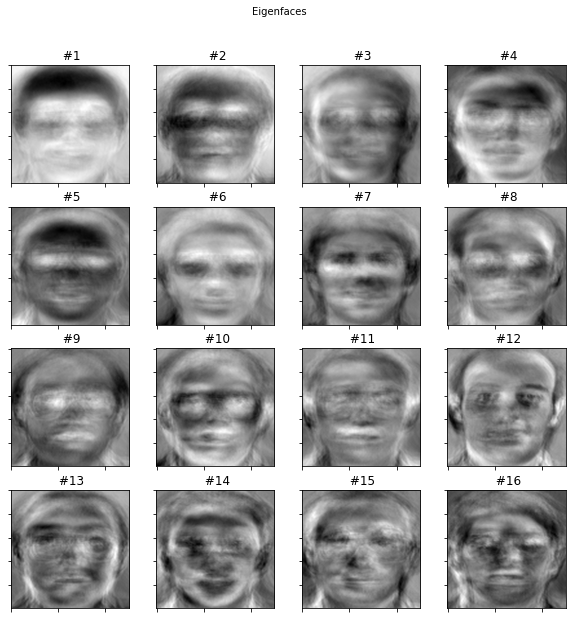

In [7]:
def subplot(title ,images ,rows ,cols ,sptitle ="",sptitles =[] ,colormap = plt.cm.gray, filename = None, figsize=(10, 10)):
    fig = plt.figure(figsize = figsize) #initializing the figure
    fig.text(.5, .95, title, horizontalalignment ="center")
    for i in range(len(images)):
        ax0 = fig.add_subplot(rows ,cols ,(i+1))
        plt.setp(ax0.get_xticklabels() ,visible = False)
        plt.setp(ax0.get_yticklabels() ,visible = False)
        if len(sptitles) == len(images):
            plt.title("%s #%s" %(sptitle, str(sptitles[i])))
        else:
            plt.title("%s #%d" %(sptitle, (i+1)))
        plt.imshow(np.asarray(images[i]), cmap = colormap)
    if filename is None :
        plt.show()
    else:
        fig.savefig(filename)

        
A = []
number = eigenvectors.shape[1]
for i in range (min(number, 16)):#plotting 16 images for visualizing the eigenfaces
    e = eigenvectors[:,i].reshape(X[0].shape)
    A.append(np.asarray(e))
subplot(title ="Eigenfaces", images=A, rows =4, cols =4, colormap =plt.cm.gray)

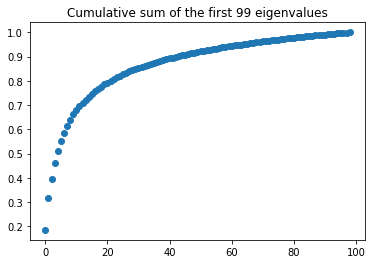

In [8]:
#This plot shows the improving accuracy as we increase the number of components in our PCA algorithm
def get_eigenvalue_distribution(eigenvectors):
    return np.cumsum(eigenvectors)/np.sum(eigenvectors)

def plot_eigenvalue_distribution(eigenvectors, interval):
    plt.scatter(interval, get_eigenvalue_distribution(eigenvectors)[interval])

plot_eigenvalue_distribution(eigenvalues, range(0, number))
plt.title("Cumulative sum of the first {0} eigenvalues".format(number))
plt.show()

C:\Users\Haikoo Khandor\AppData\Local\Temp\ipykernel_6920\1357855690.py:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize (default_size , Image.ANTIALIAS )


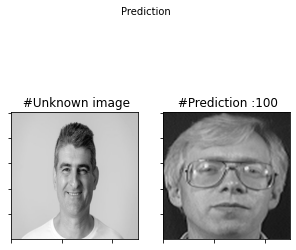

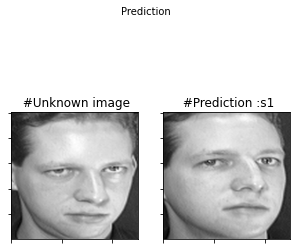

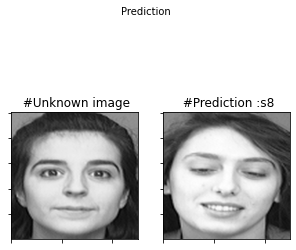

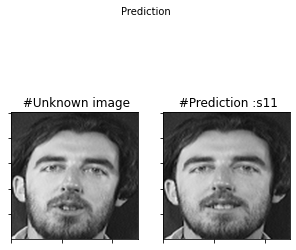

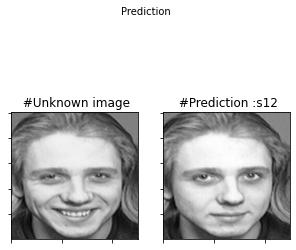

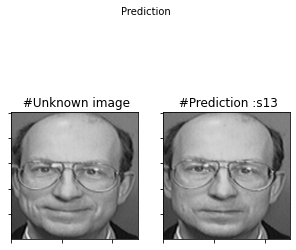

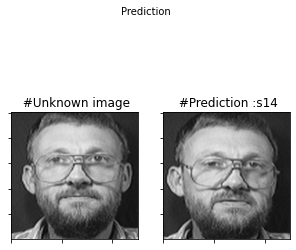

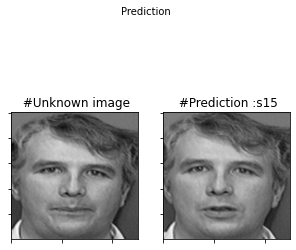

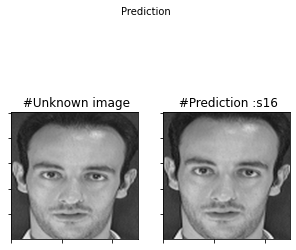

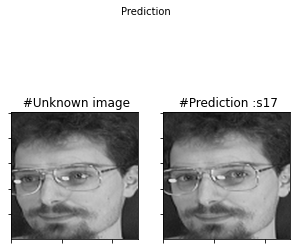

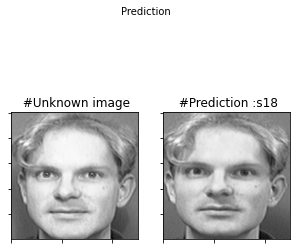

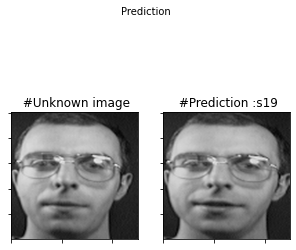

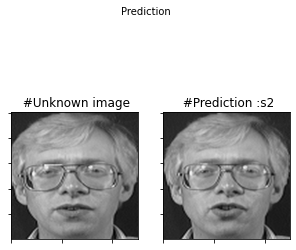

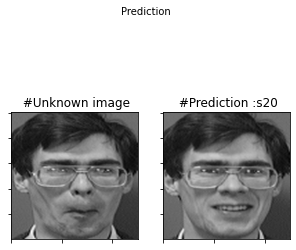

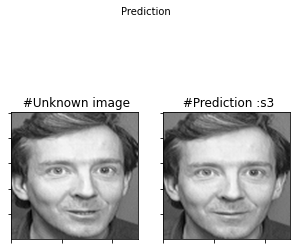

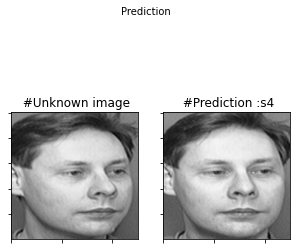

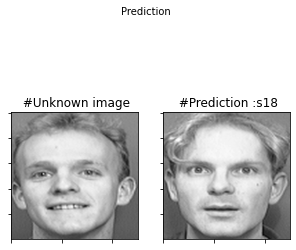

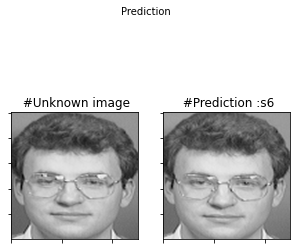

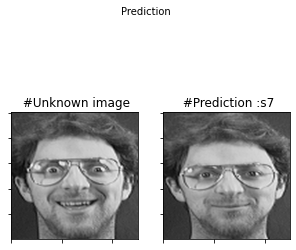

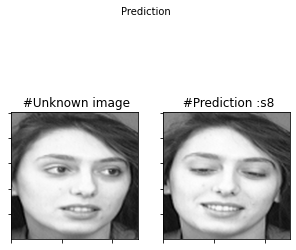

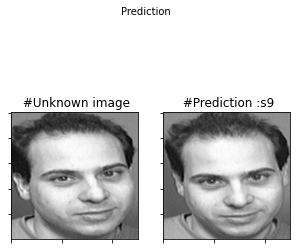

In [9]:
def projection (W , X , mu):
    return np.dot (X - mu , W)

def distance(p,q):
    p = np.asarray(p).flatten()
    q = np.asarray (q).flatten()
    return np.sqrt(np.sum(np.power((p-q),2)))

def predict(W, mu , projections, y, X):
    threshold = float(15000) #threshold, if the distance is >15000, it is characterized as Out of Distributionn(OOD) image
    pred_class = -1 #predicted class initialized
    Q = projection(W, X.reshape(1, -1), mu)
    for i in range(len(projections)):
        dist = distance(projections[i], Q)
        if dist<threshold:
            threshold = dist
            pred_class = i
    if(threshold==float(15000)):
        return 100 # marker for OOD image
    return pred_class

projections = []
for xi in X:
    projections.append(projection (eigenvectors, xi.reshape(1 , -1) , mean))
[X1, y1] = read_images(image_path='testing-images-2', default_size=image_size) #applying on the test images
predictions = []
for i in range(len(X1)):
    predicted = predict(eigenvectors, mean , projections, y, X1[i])
    predictions.append(y[predicted])
    if(predicted==100):
        subplot (title ="Prediction", images =[X1[i], X[predicted]], rows =1, cols =2, sptitles = ["Unknown image", "Prediction :{0}".format(100)] ,colormap =plt.cm.gray ,
         figsize = (5,5))
    else:
        subplot (title ="Prediction", images =[X1[i], X[predicted]], rows =1, cols =2, sptitles = ["Unknown image", "Prediction :{0}".format(y[predicted])] , colormap =plt.cm.gray , 
         figsize = (5,5))

In [10]:
#accuracy calculation along with wrong results - out of distribution images
correct = 0 # correct predictions
print("Incorrect predictions:")
for i in range(len(y1)):
    if (y1[i]==predictions[i]):
        correct+=1
    else:
        print(predictions[i], end=" ")
print("\n")
accuracy = float(correct/len(y1))
print("Accuracy:", accuracy)


Incorrect predictions:
s2 s8 s18 

Accuracy: 0.8571428571428571


References:

1. https://www.face-rec.org/algorithms/PCA/jcn.pdf
2. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=139758&tag=1